In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [4]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    # DS['TKE'].attrs['units']   = 'm2/s2'
    # DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )
    
    # DS['WindMagnitude'].attrs['units']   = 'm/s'
    # DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DS.P0.values/100        # mb 
#     hyam   = np.squeeze(DS.hyam.values)[:]
#     hybm   = np.squeeze(DS.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL','WindMagnitude','CONCLD','QT','GCLDLWP',
#                           'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
#                           'edmf_upbuoy','edmf_updet','edmf_upent',
#                           ## Add budget terms 
                          # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                          # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                           'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                           'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                          'wpthlp','wprtp','rtp2',
                          'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                          # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                          # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                          # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                          # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                          # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                          # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                          ])

    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

    # - - - - - - - - - - - - - - - - - - - - - - - -
      
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()

    ## Compute vertical velocity as m/s rather than Pa/s 
    w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
                               np.squeeze(DS['levInterp'].values)*units.hPa, 
                               np.squeeze(DS['T_interp'].values)*units.K )
    w_mps_save = np.full([len(DS.time.values), 
                      len(DS.levInterp.values), 
                      len(DS.lat.values), 
                      len(DS.lon.values)], np.nan)
    w_mps_save[:,:,0,0] = w_mps
    
    DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
                
    return DS

def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                          'edmf_qtflxup','edmf_thlflxup',
                           ])
    
#     ## Get averages for ensembles that don't include zeros.... 
#     nTime = len(DS.time.values)

#     for iT in range(nTime):
#         selDS_h2 = scamDS_h2.isel(case=iCase, time=iT, lat=0, lon=0)

#         for iL in range(len(scamDS_h2.ilev.values)):
#             ivalPlumes = np.where( (selDS_h2.edmf_upthl.values!=0) &   # [ens,ilev]
#                                    (np.isfinite(selDS_h2.edmf_upthl.values)==True)
#                                    (selDS_h2.edmf_upa.values!=0) )[0]




    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

def process_camData_h3(DS, DSctrl):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
                        'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
                        'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
                        'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
                           ])
    
    for iVar in range(len(varSels)): 

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS


In [5]:
def preprocess_h0(ds):
    
#     keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
#                 'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
#                 ## Add budget terms 
#                 # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
#                 'wpthlp','wprtp',
#                 # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
#                 ]
    
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
#                 'WPRTP2_CLUBB','WPTHLP2_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WPRTPTHLP_CLUBB',
#                 'WP2THLP_CLUBB','WPTHLP2_CLUBB','WPRTPTHLP_ZM_CLUBB',
#                 'WP4_CLUBB','WPRTP2_ZM_CLUBB','WPTHLP2_ZM_CLUBB','WP2RTP_ZM_CLUBB','WP2THLP_ZM_CLUBB',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                # 'PRECZ',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

def preprocess_h1(ds):
    
    keepVars = [
#                 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                'wpthlp','wprtp','rtp2',
                'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
#                 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel


def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
#     dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel


def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

## Read some data

In [6]:
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_clmInit_latestMergeMar15_addTQvar.003.LASSO_20180605'
caseDir  = '/project/amp/mdfowler/cases/'+caseName+'/run/atm/hist/'

## Get list of files 
listFiles_h0 = np.sort(glob.glob(caseDir+'*cam.h0*'))
listFiles_h1 = np.sort(glob.glob(caseDir+'*cam.h1*'))
listFiles_h2 = np.sort(glob.glob(caseDir+'*cam.h2*'))
listFiles_h3 = np.sort(glob.glob(caseDir+'*cam.h3*'))

ds_h0 = xr.open_dataset(listFiles_h0[0], decode_times=False)
ds_h0 = cesm_correct_time(ds_h0)

ds_h1 = xr.open_dataset(listFiles_h1[0], decode_times=False)
ds_h1 = cesm_correct_time(ds_h1)

ds_h2 = xr.open_dataset(listFiles_h2[0], decode_times=False)
ds_h2 = cesm_correct_time(ds_h2)

ds_h3 = xr.open_dataset(listFiles_h3[0], decode_times=False)
ds_h3 = cesm_correct_time(ds_h3)



In [7]:
var1    = ['up_macmic1', 'dn_macmic1','upa_macmic1','dna_macmic1',
           'thlu_macmic1','qtu_macmic1','thld_macmic1','qtd_macmic1']

var2    = ['up_macmic2', 'dn_macmic2','upa_macmic2','dna_macmic2',
           'thlu_macmic2','qtu_macmic2','thld_macmic2','qtd_macmic2']

varSave = ['up_macmicAvg', 'dn_macmicAvg','upa_macmicAvg','dna_macmicAvg',
           'thlu_macmicAvg','qtu_macmicAvg','thld_macmicAvg','qtd_macmicAvg']

for iVar in range(len(var1)):
    print('Computing %s' % (varSave[iVar]))
    
    varCyc1 = ds_h3[var1[iVar]].isel(lat=0, lon=0)
    varCyc2 = ds_h3[var2[iVar]].isel(lat=0, lon=0)
    
    ## This seems to work... 
    s = np.stack((varCyc1, varCyc2))
#     C = np.nansum(s, axis=0)
    C = np.nanmean(s, axis=0)
    C[np.all(np.isnan(s), axis=0)] = np.nan
    
    ds_h2[varSave[iVar]]  = (('time','nens','ilev'), np.squeeze(C))


Computing up_macmicAvg
Computing dn_macmicAvg
Computing upa_macmicAvg
Computing dna_macmicAvg
Computing thlu_macmicAvg
Computing qtu_macmicAvg
Computing thld_macmicAvg
Computing qtd_macmicAvg


In [11]:
edmf_wp2 = np.zeros([len(ds_h2.time.values),
                     len(ds_h2.ilev.values)])

edmf_wpthlp = np.zeros([ len(ds_h2.time.values),
                        len(ds_h2.ilev.values)])

edmf_wprtp = np.zeros([ len(ds_h2.time.values),
                       len(ds_h2.ilev.values)])

edmf_thlp2 = np.zeros([len(ds_h2.time.values),
                       len(ds_h2.ilev.values)])

edmf_rtp2 = np.zeros([len(ds_h2.time.values),
                      len(ds_h2.ilev.values)])

edmf_aw = np.zeros([len(ds_h2.time.values),
                      len(ds_h2.ilev.values)])


for iEns in range(len(ds_h2.nens.values)):
    selEns   = ds_h2.isel(nens = iEns, lat=0,lon=0)
    
    edmf_wp2 = ( edmf_wp2 + (selEns.upa_macmicAvg.values * 
                ((selEns.up_macmicAvg.values)**2)) + 
                (selEns.dna_macmicAvg.values * 
                ((selEns.dn_macmicAvg.values)**2)) )

    
    edmf_wpthlp = ( edmf_wpthlp + (selEns.upa_macmicAvg.values * 
            ((selEns.up_macmicAvg.values)*(selEns.thlu_macmicAvg.values - ds_h1.thlm.isel(lat=0,lon=0).values)) ) + 
            (selEns.dna_macmicAvg.values * 
            ((selEns.dn_macmicAvg.values)*(selEns.thld_macmicAvg.values - ds_h1.thlm.isel(lat=0,lon=0).values)) ) )

    edmf_wprtp = ( edmf_wprtp + (selEns.upa_macmicAvg.values * 
            ((selEns.up_macmicAvg.values)*(selEns.qtu_macmicAvg.values - ds_h1.rtm.isel(lat=0,lon=0).values)) ) + 
            (selEns.dna_macmicAvg.values * 
            ((selEns.dn_macmicAvg.values)*(selEns.qtd_macmicAvg.values - ds_h1.rtm.isel(lat=0,lon=0).values)) ) )

    
    edmf_thlp2 = ( edmf_thlp2 + (selEns.upa_macmicAvg.values * 
                ((selEns.thlu_macmicAvg.values - ds_h1.thlm.isel(lat=0,lon=0).values)**2)) + 
                (selEns.dna_macmicAvg.values * 
                ((selEns.thld_macmicAvg.values - ds_h1.thlm.isel(lat=0,lon=0).values)**2)) )
        
    edmf_rtp2 = ( edmf_rtp2 + (selEns.upa_macmicAvg.values * 
                ((selEns.qtu_macmicAvg.values - ds_h1.rtm.isel(lat=0,lon=0).values)**2)) + 
                (selEns.dna_macmicAvg.values * 
                ((selEns.qtd_macmicAvg.values - ds_h1.rtm.isel(lat=0,lon=0).values)**2)) )

    edmf_aw = ( edmf_aw + (selEns.upa_macmicAvg.values * 
                ((selEns.up_macmicAvg.values))) + 
                (selEns.dna_macmicAvg.values * 
                ((selEns.dn_macmicAvg.values))) )
    

    


In [12]:
ds_h2['edmf_thlflxup'].isel(lat=0, lon=0, ilev=-5).values[200:220]

array([0.0146912 , 0.01465936, 0.03437939, 0.02662146, 0.01718109,
       0.01893472, 0.01022806, 0.01058257, 0.00777084, 0.00894934,
       0.01599378, 0.01866242, 0.01229621, 0.00972023, 0.0128391 ,
       0.01297223, 0.01384269, 0.00951358, 0.00976832, 0.00314572],
      dtype=float32)

In [13]:
edmf_wpthlp[200:220, -5]

array([0.01905448, 0.01389007, 0.02087249, 0.01536046, 0.01663178,
       0.01509671, 0.01407476, 0.00885713, 0.01034678, 0.00668727,
       0.01340202, 0.02284983, 0.01171722, 0.00933775, 0.01466508,
       0.01304491, 0.01785946, 0.01107766, 0.01044078, 0.00893511])

In [14]:
100*(edmf_wpthlp[200:220, -5] - (ds_h2['edmf_thlflxup'].isel(lat=0, lon=0, ilev=-5).values[200:220]))/ds_h2['edmf_thlflxup'].isel(lat=0, lon=0, ilev=-5).values[200:220]

array([ 29.6999432 ,  -5.24773876, -39.28779093, -42.30048326,
        -3.19722279, -20.26968015,  37.60924585, -16.30457351,
        33.14882001, -25.27638837, -16.20483096,  22.43769636,
        -4.70869056,  -3.93493178,  14.2219795 ,   0.56029395,
        29.01723944,  16.44051994,   6.88404513, 184.04007382])

In [15]:
edmf_thlp2[200:220, -5]

array([0.00205788, 0.00143382, 0.00213427, 0.00155188, 0.00182876,
       0.00158098, 0.0015189 , 0.00085562, 0.00102477, 0.00058811,
       0.00131175, 0.00232697, 0.00113892, 0.00084372, 0.00147625,
       0.00130897, 0.00184395, 0.00113187, 0.00103038, 0.00088735])

In [17]:
ds_h2.edmf_S_ATHLTHL.isel(lat=0,lon=0,ilev=-5).values[200:220]

array([7.1111345, 6.7070937, 9.735567 , 9.365658 , 7.123408 , 7.7595844,
       5.158953 , 5.18479  , 4.527732 , 5.1227307, 6.4256783, 6.9663234,
       5.8579874, 5.7219677, 6.086755 , 6.2384   , 5.870819 , 5.6701403,
       4.636135 , 2.60277  ], dtype=float32)

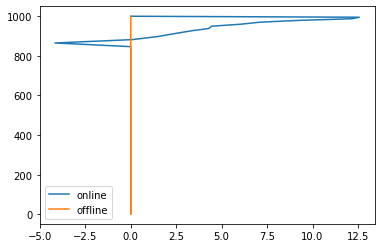

In [19]:
plt.plot(ds_h2.edmf_S_ATHLTHL.isel(lat=0,lon=0,time=200).values, ds_h2.ilev.values, label='online')
plt.plot(edmf_thlp2[200,:], ds_h2.ilev.values, label='offline')
plt.legend()

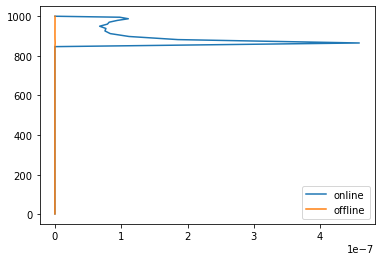

In [20]:
plt.plot(ds_h2.edmf_S_AQTQT.isel(lat=0,lon=0,time=200).values, ds_h2.ilev.values, label='online')
plt.plot(edmf_rtp2[200,:], ds_h2.ilev.values, label='offline')
plt.legend()